The following methods are used to create the training, validation, and test sets

In [36]:
# Read lines from file
def read_file(path):
    lines = []
    with open(path) as f:
        lines = f.readlines()
    return lines

In [37]:
# Load data from folder
# Returns a dataframe object with reviews, sentiment (1 for positive and 0 for negative),
# rating (1-10), and url, which specifies the movie the review was for.

import pandas as pd 
import numpy as np
import random

def load_data(path):
    neg_path = path + 'neg/'
    pos_path = path + 'pos/'

    urls_neg_path = path + 'urls_neg.txt'
    urls_pos_path = path + 'urls_pos.txt'

    urls_neg = read_file(urls_neg_path)
    urls_pos = read_file(urls_pos_path)

    reviews = []
    sentiment = []
    ratings = []
    urls = []

    for path in [neg_path, pos_path]:	
        for file in os.listdir(path):
            id_, rating_ = file[:-4].split('_')
            review = None
            with open(path + file) as f:
                review = f.read()
            reviews.append(review)
            ratings.append(rating_)

            if path == neg_path:
                sentiment.append(0)
                urls.append(urls_neg[int(id_)])
            else:
                sentiment.append(1)
                urls.append(urls_pos[int(id_)])

    df = pd.DataFrame({'reviews': reviews, 'sentiment': sentiment, 'rating': ratings, 'url': urls})
    return df 

Load in the training and test sets from the Stanford IMDb movie review dataset.

In [38]:
train_path = './aclImdb/train/'
test_path = './aclImdb/test/'
train = load_data(train_path)
test = load_data(test_path)

Create training and validation sets from original training set in movie review dataset.

In [39]:
import os 

# Method used to split the training set into training and validation sets.
# If training and validation sets are already created, it just loads them
# in from csv files unless new is set to True.
def train_val_split(df, new=False):
    """
    @param df: DataFrame object to create validation and training sets from
    @param new: Boolean value indicating whether to create new validation and
    training sets or just load previously created ones
    """
    # Check to see if train and validation csvs already created
    if 'train.csv' in os.listdir('.') and 'validation.csv' in os.listdir('.') and not new:
        train_set = pd.read_csv('train.csv', header=0)
        validation_set = pd.read_csv('validation.csv', header=0)
    else:
        VAL_SIZE = 5000

        movies = list(df['url'].unique())
        validation_set = pd.DataFrame()

        # Prevent movie overlap in new training and validation sets
        while len(validation_set) < VAL_SIZE:
            number = np.random.randint(0, len(movies) - 1)
            movie_id = movies[number]
            ratings_for_movie = df[df['url'] == movie_id]
            validation_set = pd.concat([validation_set, ratings_for_movie])
            movies.remove(movie_id)

        train_set = df[df['url'].isin(movies)]

        # Save train and validation sets
        train_set.to_csv('train_.csv', index=False)
        validation_set.to_csv('validation_.csv', index=False)

    return validation_set, train_set

val, train = train_val_split(train)

Now that we have training, validation, and test sets, we need to create different tokenizations for them.

In [40]:
import spacy
import re
import string
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
import pickle

# Tokenize dataset using a particular scheme. 
# Returns tokenized dataset.
def tokenize_dataset(dataset, scheme, pos=['all']):
    """
    @params dataset: A list of reviews/samples to be tokenized
    @params scheme: A list of words specifying the tokenization to be performed.
    'stem' stems words according to spacy's Lemmatizer. 'stop words' removes stop
    words according to nltk's corpus. 'lowercase' converts all words to lowercase.
    'punctuation' removes expressions containing only punctuation. 'whitespace'
    removes expressions containing only whitespace characters. 
    @params pos: A list of parts of speech to include. The parts of speech
    are determined using spacy's en_core_web_sm tokenizer.
    
    Returns: The tokenized dataset
    
    """
    token_dataset = []
    all_tokens = []

    tokenizer = spacy.load('en_core_web_sm')
    for sample in dataset:
        tokens = tokenizer(sample)

        if 'all' not in pos:
            tokens = [token for token in tokens if token.pos_ in pos]
        
        if 'stem' in scheme:
            lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
            tokens = [lemmatizer(token.text, token.pos_)[0] for token in tokens]

        if 'stop words' in scheme:
            if type(tokens[0]) is not str:
                tokens = [token.text for token in tokens]

            nltk_stopwords = []
            with open('nltk_english_stopwords') as f:
                nltk_stopwords = f.readlines()
                nltk_stopwords = [stopword.strip() for stopword in nltk_stopwords]

            tokens = [token for token in tokens if token not in nltk_stopwords]

        if 'lowercase' in scheme:
            if len(tokens) > 0 and type(tokens[0]) is not str:
                tokens = [token.text for token in tokens]

            tokens = [token.lower() for token in tokens]

        if 'punctuation' in scheme:
            if type(tokens[0]) is not str:
                tokens = [token.text for token in tokens]

            tokens = [token for token in tokens if len(re.findall("^[" + string.punctuation +"]+$", token)) == 0]

        if 'whitespace' in scheme:
            if type(tokens[0]) is not str:
                tokens = [token.text for token in tokens]

            tokens = [token for token in tokens if len(re.findall("^[" + string.whitespace + "]+$", token)) == 0]

        if len(tokens) > 0 and type(tokens[0]) is not str:
            tokens = [token.text for token in tokens]

        token_dataset.append(tokens)

    return token_dataset

schemes = [[], ['whitespace'], ['punctuation'], ['lowercase'], ['stop words'], ['stem'], 
           ['punctuation', 'whitespace', 'stop words', 'stem'], ['lowercase'],
           ['lowercase'], ['lowercase'], ['lowercase']]
pos = [['all'], ['all'], ['all'], ['all'], ['all'], ['all'], ['all'], ['NOUN'], ['ADJ'], ['VERB'], ['ADJ', 'NOUN','VERB']]
filenames = ['d.p', 'ws.p', 'punct.p', 'lower.p', 'sw.p', 'stem.p', 'p_ws_sw_stem_l.p', 'n_l.p', 'a_l.p', 'v_l.p', 'a_n_v_l.p']


# Create tokenizations. This code takes a long time to run. The tokenizations are already in the tokenizations folder.
####################################
# args = zip(schemes, pos, filenames)

# # Get reviews for each dataset
# train_reviews = train['reviews']
# val_reviews = val['reviews']
# test_reviews = test['reviews']

# for scheme, pos, filename in args:
#     train_tokens = tokenize(train_reviews, scheme, pos)
#     val_tokens = tokenize(val_reviews, scheme, pos)
#     test_tokens = tokenize(test_reviews, scheme, pos)
    
#     tokenized_datasets = {}
#     tokenized_datasets['training'] = train_tokens
#     tokenized_datasets['validation'] = val_tokens
#     tokenized_datasets['test'] = test_tokens
    
#     # Save tokenization for later
#     with open(filename, 'wb') as f:
#         pickle.dump(tokenized_datasets, f)
#####################################   

The following are functions used to help create the dataset indices.

In [41]:
from collections import Counter

PAD_IDX = 0
UNK_IDX = 1

# Creates the n-grams from dataset tokens given the size n.
def create_ngrams(dataset_tokens, n):
    """
    @param dataset_tokens: A list of dataset tokens to convert into n-grams
    @param n: The size of the n-gram 
    """
    all_ngrams = []
    dataset_ngrams = []

    for tokens in dataset_tokens:
        n_grams = []
        for i in range(n, len(tokens)+1):
            n_grams.append(tuple(tokens[i-n:i]))

        dataset_ngrams.append(n_grams)
        all_ngrams += n_grams

    return dataset_ngrams, all_ngrams

# Creates the token2id and id2token mappings for a vocabulary. From Lab3 BagOfWords.
def build_vocabulary(all_ngrams, size):
    """
    @param all_ngrams: A list of all the n-grams to create the mappings from
    @param size: The size of the vocabulary
    """
    token_counter = Counter(all_ngrams)
    vocab, count = zip(*token_counter.most_common(size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2, 2+len(vocab))))
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# Converts the tokens in the dataset to indices. From Lab3 BagOfWords.
def token2index_dataset(tokens_dataset, token2id):
    """
    @param tokens_dataset: A list of n-grams to convert into indices
    @param token2id: A mapping from an n-gram to an index
    """
    indices_data = []
    for tokens in tokens_dataset:
        if len(tokens) == 0:
            index_list = [UNK_IDX]
        else:
            index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

The following is the data loader class modified slightly from Lab 3. The collate_function is included in the class as well as the sentence length value.

In [42]:
import torch
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable
    for PyTorch. Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list, target_list, sentence_length):
        """
        @param data_list: list of movie review tokens
        @param target_list: list of movie review targets
        """
        self.data_list = data_list
        self.target_list = target_list
        self.sentence_length = sentence_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]. This is just a nice way
        to get the data and target for a specific instance in the 
        dataset.
        """

        token_idx = self.data_list[key][:self.sentence_length]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

    def imdb_collate_func(self, batch):
        """
        Customized function for DataLoader that dynamically pads the batch so 
        that all the data have the same length
        """
        data_list = []
        label_list = []
        length_list = []

        for datum in batch:
            label_list.append(datum[2])
            length_list.append(datum[1])

        for datum in batch:
            padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0, (self.sentence_length)-datum[1])),
                                mode="constant", constant_values=0)
            data_list.append(padded_vec)
        return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

Below is a modified BagOfWords class from Lab 3. The class is expanded to include the hyperparameters, datasets, and functions necessary to train and evaluate itself. 

In [43]:
import torch.nn as nn
import torch.nn.functional as F

# A mapping from tokenization schemes to their files
SCHEMES_TO_FILES = {'a_n_v_l': './tokenizations/a_n_v_l.p',
                    'a_l': './tokenizations/a_l.p',
                    'd': './tokenizations/d.p',
                    'l': './tokenizations/l.p',
                    'n_l': './tokenizations/n_l.p',
                    'p': './tokenizations/p.p',
                    'sw': './tokenizations/sw.p',
                    'v_l': './tokenizations/v_l.p',
                    'ws': './tokenizations/ws.p',
                    'stem': './tokenizations/stem.p',
                    'p_ws_sw_stem_l': './tokenizations/p_ws_sw_stem_l.p'   
}


class SentimentBagOfWords(nn.Module):
    """
    BagOfWords model for sentiment classifcation. Modified from lab 3, so that it includes
    its own hyperparameters, datasets, and functions for training and evaluating performance.
    """
    def __init__(self, hyperparameters, name, datasets):
        """
        @param hyperparameters: a dictionary containing the hyperparameters to use
        for the model.
        @param datasets: a dictionary containing the training, validation, and test
        datasets.
        @param name: a name for the model
        """
        super(SentimentBagOfWords, self).__init__()
        
        # Hyperparameters
        self.learning_rate = hyperparameters['learning_rate']
        self.epoch = hyperparameters['epoch']
        self.batch_size = hyperparameters['batch_size']
        self.vocabulary_size = hyperparameters['vocabulary_size']
        self.embedding_size = hyperparameters['embedding_size']
        self.tokenization = hyperparameters['tokenization']
        self.n_grams = hyperparameters['n-grams']
        self.optimizer = hyperparameters['optimizer']
        self.sentence_length = hyperparameters['sentence_length']

        # Datasets
        self.training = datasets['train']
        self.val = datasets['val']
        self.test = datasets['test']

        self.name = name 

        self.embed = nn.Embedding(self.vocabulary_size+2, self.embedding_size, padding_idx=0)
        self.linear = nn.Linear(self.embedding_size, 2)
    
        # Stores the indices for each dataset
        self.data_indices = {}

        # Stores the validation accuracies
        self.val_accs = []
        # Stores the training accuracies
        self.train_accs = []
        # Stores the validation losses
        self.val_losses = []
        # Stores the training losses
        self.train_losses = []
        # Stores the epoch time intervals
        self.x = []
        
        # Create data indices upon initialization
        self.create_indices()
    
    # Creates indices for each dataset
    def create_indices(self):
        tokenized_file = SCHEMES_TO_FILES[self.tokenization]
        with open(tokenized_file, 'rb') as f:
            tokenized_data = pickle.load(f)

        training = tokenized_data['training']
        validation = tokenized_data['validation']
        test = tokenized_data['test']

        train_data_tokens, all_train_tokens = create_ngrams(training, self.n_grams)
        val_data_tokens, _ = create_ngrams(validation, self.n_grams)
        test_data_tokens, _ = create_ngrams(test, self.n_grams)

        token2id, id2token = build_vocabulary(all_train_tokens, self.vocabulary_size)

        train_indices = token2index_dataset(train_data_tokens, token2id)
        val_indices = token2index_dataset(val_data_tokens, token2id)
        test_indices = token2index_dataset(test_data_tokens, token2id)

        self.data_indices['train'] = train_indices
        self.data_indices['val'] = val_indices
        self.data_indices['test'] = test_indices

    def forward(self, data, length):

        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()

        # return logits
        out = self.linear(out.float())
        return out 

    # Helper function to train model
    def train_model(self):
        # Create data loaders for train, test, and validation sets
        self.create_loaders()

        # Flag to indicate scheduler
        self.scheduler = False

        criterion = torch.nn.CrossEntropyLoss()

        # Check to see if learning rate is with annealing or without
        if type(self.learning_rate) is dict:
            step_size = self.learning_rate['stepsize']
            gamma = self.learning_rate['gamma']
            lr = self.learning_rate['lr']
            self.scheduler = True
            if self.optimizer == 'Adam':
                optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            else:
                optimizer = torch.optim.SGD(self.parameters(), lr=lr)
            # Create learning rate scheduler for annealing
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)
        # Set optimizer
        elif self.optimizer == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        
        # Train
        for epoch in range(self.epoch):
            if self.scheduler:
                scheduler.step()
            for i, (data, lengths, labels) in enumerate(self.train_loader):
                self.train()
                data_batch, length_batch, label_batch = data, lengths, labels
                optimizer.zero_grad()

                outputs = self(data_batch, length_batch)
                loss = criterion(outputs, label_batch)
                loss.backward()
                optimizer.step()

                if i > 0 and i % 25 == 0:
                    val_acc, val_loss = self.test_model(self.val_loader) # Evaluate on validation set
                    train_acc, train_loss = self.test_model(self.train_loader) # Evaluate on training set
                    self.val_accs.append(val_acc)
                    self.val_losses.append(val_loss)
                    self.train_accs.append(train_acc)
                    self.train_losses.append(train_loss)
                    self.x.append(epoch + (i + 1) / len(self.train_loader))
        
        # Return a dictionary containing performance on validation and training set
        return {self.name: {'x': self.x, 'val_acc':self.val_accs, 'val_loss':self.val_losses, 'train_acc':self.train_accs, 'train_loss':self.train_losses}}

    # Evaluate performance of model on given dataset specified by loader
    def test_model(self, loader):
        """
        Help function that tests the model's performance on the validation dataset
        """
        criterion = torch.nn.CrossEntropyLoss()
        correct = 0
        total = 0
        cumulative_loss = 0
        self.eval()
        for data, lengths, labels in loader:
            data_batch, length_batch, label_batch = data, lengths, labels 
            outputs = F.softmax(self(data_batch, length_batch), dim=1)

            loss = criterion(outputs, label_batch)
            cumulative_loss += loss.item()

            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            
        return (100 * correct / total), cumulative_loss / len(loader)

    # Create dataloaders for training, testing, and validation set
    def create_loaders(self):
        train_dataset = IMDBDataset(self.data_indices['train'], self.training['sentiment'], self.sentence_length)
        self.train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                        batch_size=self.batch_size,
                                                        collate_fn=train_dataset.imdb_collate_func,
                                                        shuffle=True)
        val_dataset = IMDBDataset(self.data_indices['val'], self.val['sentiment'], self.sentence_length)
        self.val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                      batch_size=self.batch_size,
                                                      collate_fn=val_dataset.imdb_collate_func,
                                                      shuffle=True)
        test_dataset = IMDBDataset(self.data_indices['test'], self.test['sentiment'], self.sentence_length)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                       batch_size=self.batch_size,
                                                       collate_fn=test_dataset.imdb_collate_func,
                                                       shuffle=False)
    
    # Print the hyperparameters associated with the model
    def print_hyperparameters(self):
        print("Learning Rate:", self.learning_rate) 
        print("Epoch", self.epoch)
        print("Batch Size:", self.batch_size)
        print("Vocabulary Size:", self.vocabulary_size)
        print("Embedding Size:", self.embedding_size)
        print("Tokenization:", self.tokenization)
        print("N-grams:", self.n_grams)
        print("Optimizer:", self.optimizer)
        print("Sentence Length:", self.sentence_length)
        print("Name:", self.name)

In [58]:
import multiprocessing as mp
import matplotlib.pyplot as plt 
%matplotlib inline

#A function that takes in a string that looks like a dictionary and converts it to a dictionary object
def string_to_dictionary(str_dict):
    empty_dict = {}
    str_dict = str_dict.strip('{')
    str_dict = str_dict.strip('}')

    key_value_pairs = str_dict.split(',')
    for key_value in key_value_pairs:
        key = key_value.split(':')[0]
        key = key.strip()
        key = key.strip("'")
        if key == 'step_size':
            val = int(key_value.split(':')[1])
        else:
            val = float(key_value.split(':')[1])
        empty_dict[key] = val 
    return empty_dict


class Experiment():
    """
    An experiment class to perform ablation study on various hyperparameters
    Takes in a dictionary of default parameters and a list of hyperparameter
    values to evaluate. The class creates a set of models that differ in the
    value of one hyperparameter. The class trains and evaluates the models in parallel and
    then can return the model that performed the best and its hyperparameter value.
    """
    def __init__(self, default_hyperparameters, varied_hyperparameter, datasets, name):
        """
        @param default_hyperparameters: a dictionary containing the default hyperparameter 
        values for the models
        @param varied_hyperparameter: a dictionary with only one key that is the hyperparameter to change 
        that maps to a list of values for the hyperparameter to take on
        @param datasets: a dictionary of datasets to train and evaluate the models on
        @param name: a name for the experiment
        """
        self.configurations = []
        self.names = []
        self.datasets = datasets
        self.experiment_name = name
        param = list(varied_hyperparameter.keys())[0]
        param_values = varied_hyperparameter[param]
        for value in param_values:
            configuration = {}
            configuration.update(default_hyperparameters)
            configuration[param] = value 
            self.configurations.append(configuration)
            self.names.append(str(param) + '_' + str(value))

        self.results = {}
        # Create models
        self.models = []
        self.create_models()

    # Create models with different configurations
    def create_models(self):
        for i in range(len(self.configurations)):
            cur_configuration = self.configurations[i]
            cur_name = self.names[i]
            model = SentimentBagOfWords(cur_configuration, cur_name, self.datasets)
            self.models.append(model)

    # Create plot for the training curves and save it to filename
    def create_plot(self, filename):
        fig = plt.figure()
        ax1 = plt.subplot(221)
        ax1.set_title("Training Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.tight_layout()
        ax2 = plt.subplot(222)
        ax2.set_title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.tight_layout()
        ax3 = plt.subplot(223)
        ax3.set_title("Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.tight_layout()
        ax4 = plt.subplot(224)
        ax4.set_title("Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.tight_layout()
        
        # Colors for different lines
        colors = ['red', 'green', 'yellow', 'blue', 'orange', 'black', 'purple', 'pink', 'teal', 'gray']

        for i in range(len(self.results.keys())):
            cur_key = list(self.results.keys())[i]

            x = self.results[cur_key]['x']
            train_acc = self.results[cur_key]['train_acc']
            train_loss = self.results[cur_key]['train_loss']
            val_acc = self.results[cur_key]['val_acc']
            val_loss = self.results[cur_key]['val_loss']

            ax1.plot(x, train_acc, c=colors[i])
            ax2.plot(x, train_loss, c=colors[i])
            ax3.plot(x, val_acc, c=colors[i])
            ax4.plot(x, val_loss, label=cur_key, c=colors[i])

        handles, labels = ax4.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', prop={'size': 6})
        fig.suptitle(self.experiment_name.title())
        plt.subplots_adjust(bottom=0.25)
        plt.subplots_adjust(top=0.85)
        plt.savefig(filename)

    # Returns the model name, validation accuracy, and hyperparameter value
    # of the model that performed the best on the validation set
    def get_best(self):
        best_name = list(self.results.keys())[0]
        best_val_acc = self.results[best_name]['val_acc'][-1]
        for i in range(len(self.results.keys())):
            model_name = list(self.results.keys())[i]
            model_val_acc = self.results[model_name]['val_acc'][-1]
            if model_val_acc > best_val_acc:
                best_name = model_name
                best_val_acc = model_val_acc

        # Parse model name to get parameter value
        best_val = best_name.split('_')[-1]
        hyperparameter_name = best_name.split('_')[0]
        if hyperparameter_name == 'epoch' or hyperparameter_name == 'n-grams' or hyperparameter_name == 'vocabulary' \
        or hyperparameter_name == 'embedding' or hyperparameter_name == 'batch' or hyperparameter_name == 'sentence':
            best_val = int(best_val)
        elif hyperparameter_name == 'tokenization' or hyperparameter_name == 'optimizer':
            best_val = best_val 
        else: #learning_rate
            if best_val.find('stepsize') >= 0:
                best_val = string_to_dictionary(best_val)
            else:
                best_val = float(best_val)

        return best_name, best_val_acc, best_val 
    
    # Helper function to allow training in parallel
    def trainer_helper(self, model):
        return model.train_model()

    def run_experiment(self):
        # Train models in parallel
        # Get back validation and training scores to plot and
        # name of model
        # Store results in dictionary based on model's name
        print("Running experiment:", self.experiment_name)
        p = mp.Pool(mp.cpu_count())
        results = p.map(self.trainer_helper, self.models)

        for result in results:
            name = list(result.keys())[0]
            self.results[name] = {}
            metrics = result[name]
            for metric in metrics:
                self.results[name][metric] = metrics[metric]

        print("Finished experiment:", self.experiment_name)

    # Creates a csv of the results and saves it to filename
    def log(self, filename):
        df = pd.DataFrame()
        # Handle uneven dataframe from epoch. 
        if self.experiment_name.find('epoch') >= 0:
            # Max epoch value will have the most values
            max_value = max([model.epoch for model in self.models])
            max_length = len(self.results['epoch_' + str(max_value)]['x'])
            
            # Pad other model results with np.nan to match length of longest one
            for key in self.results.keys():
                model_results = self.results[key]
                for model_key in model_results.keys():
                    if len(model_results[model_key]) < max_length:
                        while len(model_results[model_key]) < max_length:
                            model_results[model_key].append(np.nan)
                    df[str(key)+'_'+str(model_key)] = model_results[model_key]
        
        # Handle uneven dataframe from batch
        elif self.experiment_name.find('batch') >= 0:
            # Min batch_size value will have the most values
            min_value = min([model.batch_size for model in self.models])
            max_length = len(self.results['batch_size_' + str(min_value)]['x'])
            
            # Pad other model results
            for key in self.results.keys():
                model_results = self.results[key]
                for model_key in model_results.keys():
                    if len(model_results[model_key]) < max_length:
                        while len(model_results[model_key]) < max_length:
                            model_results[model_key].append(np.nan)
                    df[str(key)+'_'+str(model_key)] = model_results[model_key]
        else:
            for key in self.results.keys():
                model_results = self.results[key]
                for model_key in model_results.keys():
                    df[str(key)+'_'+str(model_key)] = model_results[model_key]
        df.to_csv(filename, index=False)

    # Returns the models created for the experiment
    def get_models(self):
        return self.models


Now we can run experiments to determine the best configuration.

In [45]:
# Default hyperparameters to start with
default_hyperparameters = {
        'optimizer': 'Adam',
        'n-grams': 1,
        'vocabulary_size': 10000,
        'embedding_size': 100,
        'batch_size': 50,
        'sentence_length': 100,
        'learning_rate': 0.01,
        'tokenization': 'd',
        'epoch': 10
    }

# Datasets to use
datasets = {
        'train': train,
        'val': val,
        'test': test
    }

# For reproducible results
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

Learning Rate: 0.01
Epoch 10
Batch Size: 50
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: batch_size_50


Learning Rate: 0.01
Epoch 10
Batch Size: 100
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: batch_size_100


Learning Rate: 0.01
Epoch 10
Batch Size: 250
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: batch_size_250


Learning Rate: 0.01
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: batch_size_500


Running experiment: batch size ablation
Finished experiment: batch size ablation
BEST VALUE 500
NEW DEFAULT HYPERPARAMETERS {'optimizer': 'Adam', 'n-grams': 1, 'vocabulary_size': 10000, 'embedding_size': 100, 'batch_size': 500, 'sentence_length': 100, 'learning_rate': 0.01, 'tokenization': 'd', 'epoch

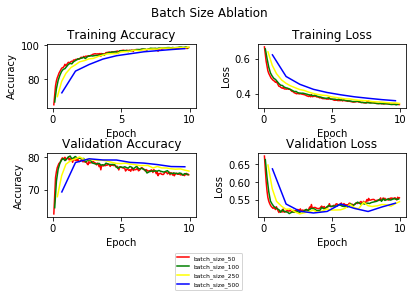

In [46]:
# Run batch sizes experiment
batch_sizes = {'batch_size': [50, 100, 250, 500]}
batch_ablation = Experiment(default_hyperparameters, batch_sizes, datasets, 'batch size ablation')
batch_models = batch_ablation.get_models()
for model in batch_models:
    model.print_hyperparameters()
    print('\n')

batch_ablation.run_experiment()

best_model_name, best_value_acc, best_value = batch_ablation.get_best()
print("BEST VALUE", best_value)
default_hyperparameters['batch_size'] = best_value 
print("NEW DEFAULT HYPERPARAMETERS", default_hyperparameters)

batch_ablation.create_plot('batch_experiment.png')
batch_ablation.log('batch_experiment_results.csv')

Learning Rate: 0.01
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: optimizer_Adam


Learning Rate: 0.01
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: SGD
Sentence Length: 100
Name: optimizer_SGD


Running experiment: optimizer ablation
Finished experiment: optimizer ablation
BEST VALUE Adam
NEW DEFAULT HYPERPARAMETERS {'optimizer': 'Adam', 'n-grams': 1, 'vocabulary_size': 10000, 'embedding_size': 100, 'batch_size': 500, 'sentence_length': 100, 'learning_rate': 0.01, 'tokenization': 'd', 'epoch': 10}


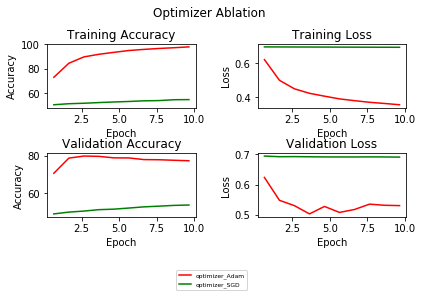

In [47]:
# Run optimizer experiment
optimizers = {'optimizer': ['Adam', 'SGD']}
optimizer_ablation = Experiment(default_hyperparameters, optimizers, datasets, 'optimizer ablation')
optimizer_models = optimizer_ablation.get_models()
for model in optimizer_models:
    model.print_hyperparameters()
    print('\n')

optimizer_ablation.run_experiment()

best_model_name, best_value_acc, best_value = optimizer_ablation.get_best()
print("BEST VALUE", best_value)
default_hyperparameters['optimizer'] = best_value 
print("NEW DEFAULT HYPERPARAMETERS", default_hyperparameters)

optimizer_ablation.create_plot('optimizer_experiment.png')
optimizer_ablation.log('optimizer_experiment_results.csv')

Learning Rate: 1
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: learning_rate_1


Learning Rate: 0.1
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: learning_rate_0.1


Learning Rate: 0.01
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: learning_rate_0.01


Learning Rate: 0.001
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: learning_rate_0.001


Learning Rate: 0.0001
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: learning_rate_0.0001


Learning Rate: {'lr': 0.1, 'gamma': 0.1, 'stepsize': 5}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Emb

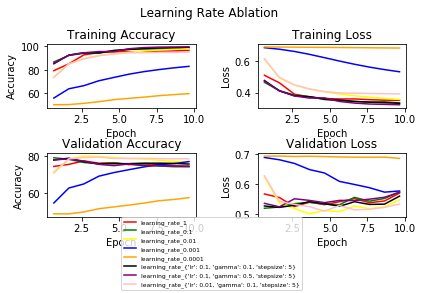

In [48]:
# Run learning rate experiment
learning_rates = {'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001, {'lr': 0.1, 'gamma': 0.1, 'stepsize': 5},
{'lr': 0.1, 'gamma': 0.5, 'stepsize': 5}, {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5}]}
learning_rate_ablation = Experiment(default_hyperparameters, learning_rates, datasets, 'learning rate ablation')
learning_rate_models = learning_rate_ablation.get_models()
for model in learning_rate_models:
    model.print_hyperparameters()
    print('\n')

learning_rate_ablation.run_experiment()

best_model_name, best_value_acc, best_value = learning_rate_ablation.get_best()
print("BEST VALUE", best_value)
default_hyperparameters['learning_rate'] = best_value 
print("NEW DEFAULT HYPERPARAMETERS", default_hyperparameters)

learning_rate_ablation.create_plot('learning_rate_experiment.png')
learning_rate_ablation.log('learning_rate_experiment_results.csv')

Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: vocabulary_size_10000


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 25000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: vocabulary_size_25000


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 50000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: vocabulary_size_50000


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 100000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: vocabulary_size_100000


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 200000
Embedd

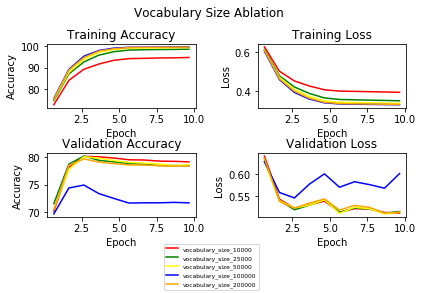

In [49]:
# Run vocabulary sizes experiment
vocabulary_sizes = {'vocabulary_size': [10000, 25000, 50000, 100000, 200000]}
vocabulary_ablation = Experiment(default_hyperparameters, vocabulary_sizes, datasets, 'vocabulary size ablation')
vocabulary_models = vocabulary_ablation.get_models()
for model in vocabulary_models:
    model.print_hyperparameters()
    print('\n')

vocabulary_ablation.run_experiment()

best_model_name, best_value_acc, best_value = vocabulary_ablation.get_best()
print("BEST VALUE", best_value)
default_hyperparameters['vocabulary_size'] = best_value 
print("NEW DEFAULT HYPERPARAMETERS", default_hyperparameters)

vocabulary_ablation.create_plot('vocabulary_experiment.png')
vocabulary_ablation.log('vocabulary_experiment_results.csv')

Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: embedding_size_100


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 200
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: embedding_size_200


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 300
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: embedding_size_300


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 500
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: embedding_size_500


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 1000


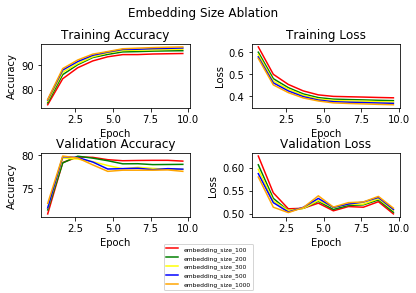

In [50]:
# Run embedding sizes experiment
embedding_sizes = {'embedding_size': [100, 200, 300, 500, 1000]}
embedding_ablation = Experiment(default_hyperparameters, embedding_sizes, datasets, 'embedding size ablation')
embedding_models = embedding_ablation.get_models()
for model in embedding_models:
    model.print_hyperparameters()
    print('\n')

embedding_ablation.run_experiment()

best_model_name, best_value_acc, best_value = embedding_ablation.get_best()
print("BEST VALUE", best_value)
default_hyperparameters['embedding_size'] = best_value 
print("NEW DEFAULT HYPERPARAMETERS", default_hyperparameters)

embedding_ablation.create_plot('embedding_ablation.png')
embedding_ablation.log('embedding_experiment_results.csv')

Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 50
Name: sentence_length_50


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 100
Name: sentence_length_100


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 250
Name: sentence_length_250


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 500
Name: sentence_length_500


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100

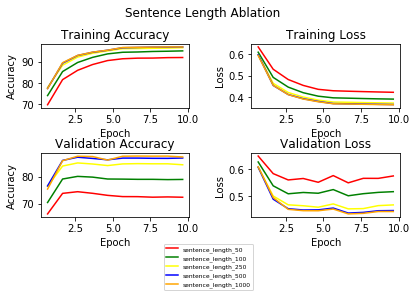

In [51]:
# Run sentence lengths experiment
sentence_lengths = {'sentence_length': [50, 100, 250, 500, 1000]}
sentence_ablation = Experiment(default_hyperparameters, sentence_lengths, datasets, 'sentence length ablation')
sentence_models = sentence_ablation.get_models()
for model in sentence_models:
    model.print_hyperparameters()
    print('\n')

sentence_ablation.run_experiment()

best_model_name, best_value_acc, best_value = sentence_ablation.get_best()
print("BEST VALUE", best_value)
default_hyperparameters['sentence_length'] = best_value 
print("NEW DEFAULT HYPERPARAMETERS", default_hyperparameters)

sentence_ablation.create_plot('sentence_ablation.png')
sentence_ablation.log('sentence_ablation_results.csv')


The tokenizations are as follows:  

d: a default tokenization, it takes what is given from the tokenizer loaded in from 'en_core_web_sm'  

ws: removes any tokens consisting of only whitespace characters  

p: removes any tokens consisting of only punctuation marks  

l: converts all tokens to lowercase  

stem: uses the lemmatizer from 'en_core_web_sm' to stem words  

p_ws_sw_stem_l: does all of the above  

n_l: keeps only nouns and converts them to lowercase, based on the part-of-speech tag assigned by the tokenizer from 'en_core_web_sm'  

a_l: keeps only adjectives and converts them to lowercase   

v_l: keeps only verbs and converts them to lowercase   

a_n_v_l: keeps adjectives, verbs, and nouns and converts them to lowercase   


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: d
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: tokenization_d


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: ws
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: tokenization_ws


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: p
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: tokenization_p


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: tokenization_l


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenizatio

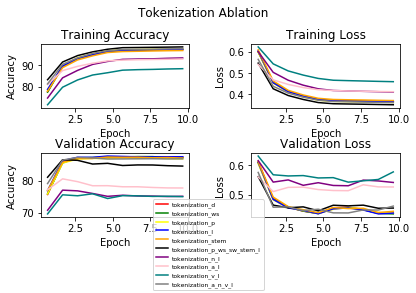

In [52]:
# Run tokenization experiment
tokenizations = {'tokenization': ['d', 'ws', 'p', 'l', 'stem', 'p_ws_sw_stem_l', 'n_l', 'a_l', 'v_l', 'a_n_v_l']}
tokenization_ablation = Experiment(default_hyperparameters, tokenizations, datasets, 'tokenization ablation')
tokenization_models = tokenization_ablation.get_models()
for model in tokenization_models:
    model.print_hyperparameters()
    print('\n')

tokenization_ablation.run_experiment()

best_model_name, best_value_acc, best_value = tokenization_ablation.get_best()
print("BEST VALUE", best_value)
default_hyperparameters['tokenization'] = best_value 
print("NEW DEFAULT HYPERPARAMETERS", default_hyperparameters)

tokenization_ablation.create_plot('tokenization_ablation.png')
tokenization_ablation.log('tokenization_ablation_results.csv')

Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: n-grams_1


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 2
Optimizer: Adam
Sentence Length: 1000
Name: n-grams_2


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 3
Optimizer: Adam
Sentence Length: 1000
Name: n-grams_3


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 4
Optimizer: Adam
Sentence Length: 1000
Name: n-grams_4


Running experiment: n-gram ablation
Finished experiment: n-gram ablation
BEST VALUE 1
NEW DEFAULT HYPERPARAMETERS {'optimizer': 'Adam', 'n-grams': 1, 'vocabular

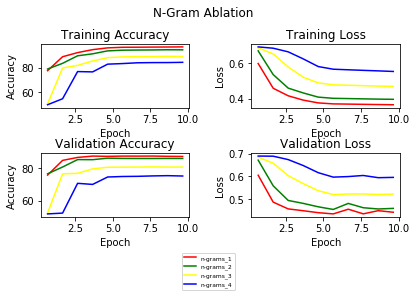

In [53]:
# Run n-grams experiment
n_grams = {'n-grams': [1, 2, 3, 4]}
n_gram_ablation = Experiment(default_hyperparameters, n_grams, datasets, 'n-gram ablation')
n_gram_models = n_gram_ablation.get_models()
for model in n_gram_models:
    model.print_hyperparameters()
    print('\n')

n_gram_ablation.run_experiment()

best_model_name, best_value_acc, best_value = n_gram_ablation.get_best()
print("BEST VALUE", best_value)
default_hyperparameters['n-grams'] = best_value 
print("NEW DEFAULT HYPERPARAMETERS", default_hyperparameters)

n_gram_ablation.create_plot('n_gram_ablation.png')
n_gram_ablation.log('n_gram_ablation_results.csv')

Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 5
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: epoch_5


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 10
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: epoch_10


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 25
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: epoch_25


Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 50
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: epoch_50


Running experiment: epoch ablation
Finished experiment: epoch ablation
BEST VALUE 5
BEST HYPERPARAMETER CONFIGURATION {'optimizer': 'Adam', 'n-grams': 1, 'vocabulary_

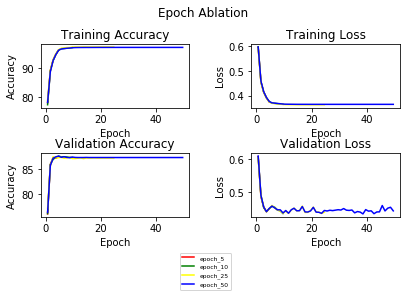

In [54]:
# Run epoch experiment
epochs = {'epoch': [5, 10, 25, 50]}
epoch_ablation = Experiment(default_hyperparameters, epochs, datasets, 'epoch ablation')
epoch_models = epoch_ablation.get_models()
for model in epoch_models:
    model.print_hyperparameters()
    print('\n')

epoch_ablation.run_experiment()

best_model_name, best_value_acc, best_value = epoch_ablation.get_best()
print("BEST VALUE", best_value)
default_hyperparameters['epoch'] = best_value 
print("BEST HYPERPARAMETER CONFIGURATION", default_hyperparameters)

epoch_ablation.create_plot('epoch_experiment.png')
epoch_ablation.log('epoch_experiment_results.csv')

Now that we have the best configuration of hyperparameters, we can train our model using these hyperparameters and evaluate its performance on the test set.

In [57]:
# Best hyperparameter configuration
best_hyperparameters = {
    'optimizer': 'Adam',
    'n-grams': 1,
    'vocabulary_size': 10000,
    'embedding_size': 100,
    'batch_size': 500,
    'sentence_length': 1000,
    'learning_rate': {'lr':0.01, 'gamma':0.1, 'stepsize':5.0},
    'tokenization': 'l',
    'epoch': 5
}

best_model = SentimentBagOfWords(best_hyperparameters, 'best', datasets)

best_model.print_hyperparameters()

results = best_model.train_model()
test_acc, test_loss = best_model.test_model(best_model.test_loader)
train_acc, train_loss = best_model.test_model(best_model.train_loader)
val_acc, val_loss = best_model.test_model(best_model.val_loader)

print("TEST ACC:", test_acc, "TEST LOSS:", test_loss)
print("TRAIN ACC:", train_acc, "TRAIN LOSS:", train_loss)
print("VAL ACC:", val_acc, "VAL LOSS", val_loss)

Learning Rate: {'lr': 0.01, 'gamma': 0.1, 'stepsize': 5.0}
Epoch 5
Batch Size: 500
Vocabulary Size: 10000
Embedding Size: 100
Tokenization: l
N-grams: 1
Optimizer: Adam
Sentence Length: 1000
Name: best
TEST ACC: 87.612 TEST LOSS: 0.4423192900419235
TRAIN ACC: 96.68834417208605 TRAIN LOSS: 0.3709599331021309
VAL ACC: 87.76447105788424 VAL LOSS 0.44261793385852466


Lastly, we need to find three correctly classified reviews and three incorrectly classified reviews in the validation set.

In [56]:
# Getting 3 incorrect and 3 correct cases from validation set
incorrect_cases = []
correct_cases = []

with open('./tokenizations/l.p', 'rb') as f:
    tokenization = pickle.load(f)

training_tokens = tokenization['training']
training_ngrams, all_ngrams = create_ngrams(training_tokens, 1)

token2id, id2token = build_vocabulary(all_ngrams, 10000)



# While we don't have three of each
while len(incorrect_cases) < 3 or len(correct_cases) < 3:
    idx = np.random.randint(len(val)) #generate random idx
    review = val['reviews'][idx] #get review
    label = val['sentiment'][idx] #get label
    tokenized_review = tokenization['validation'][idx]	#get tokenized review
    review_ngrams, _ = create_ngrams([tokenized_review], 1)
    index_review = [token2id[token] if token in token2id else UNK_IDX for token in review_ngrams[0]]
    index_review = index_review[:1000]
    length_of_review = len(index_review)
    padded_review = np.pad(np.array(index_review), pad_width=((0, (1000-length_of_review))), mode="constant", constant_values=0)
    length_batch = torch.LongTensor([length_of_review])
    data_batch = torch.from_numpy(np.array([padded_review]))
    label_batch = torch.LongTensor([label])

    # Run through model
    outputs = F.softmax(best_model(data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    correct = predicted.eq(label_batch.view_as(predicted)).sum().item()

    if correct == 1 and len(correct_cases) < 3:
        correct_cases.append((review, label, predicted))
    elif correct == 0 and len(incorrect_cases) < 3:
        incorrect_cases.append((review, label, predicted))

# Prints the correct cases (review, actual_label, predicted_label)
print("CORRECT CASES")
for case in correct_cases:
    print("CORRECT")
    print(case)
    print('\n\n')

# Prints the incorrect cases (review, actual_label, predicted_label)
print("INCORRECT CASES")
for case in incorrect_cases:
    print("INCORRECT")
    print(case)
    print('\n\n')

CORRECT CASES
CORRECT
('This movie is incredible.With great characters,specially the old swordsman that can fly in the shape of fireball and jump across the trees,this film tells a classic story of battle between good and forces of evil.The final showdown is specially breathtaking and the music score is kinda cool.<br /><br />Very,very recommendable.Not for the smallest children though.This one deserves a 10.', 1, tensor([[1]]))



CORRECT
('Where to begin? Anachronism? High tech cross bow with a scope in about 500AD? Arrows with explosive charges in 500AD? A monster Grendel that looks like a robocop and obviously never interacts with any of the weapons fired or swung against him? The heart torn out of his victim\'s chest without any sense of contact? Possibly the blond who would fit in on a recent fashion show with her make-up and streaked hair? The ancient Danish court represented in Classical Greek style? The queen played by Marina Sirtis more savaged by her makeup artist than by ma